In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gradio as gr
import janitor
from ydata_profiling import ProfileReport
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# from cleanlab import Datalab
from cleanlab.datalab.datalab import Datalab
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

# Load dataset
df = pd.read_csv("netflix_titles.csv")

C:\Users\USER-PC\anaconda3\Lib\site-packages\visions\utils\monkeypatches\imghdr_patch.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  from imghdr import tests


In [2]:
# Quick look
df.head()

show_id     type                  title         director  \
0      s1    Movie   Dick Johnson Is Dead  Kirsten Johnson   
1      s2  TV Show          Blood & Water              NaN   
2      s3  TV Show              Ganglands  Julien Leclercq   
3      s4  TV Show  Jailbirds New Orleans              NaN   
4      s5  TV Show           Kota Factory              NaN   

                                                cast        country  \
0                                                NaN  United States   
1  Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...   South Africa   
2  Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...            NaN   
3                                                NaN            NaN   
4  Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...          India   

           date_added  release_year rating   duration  \
0  September 25, 2021          2020  PG-13     90 min   
1  September 24, 2021          2021  TV-MA  2 Seasons   
2  September 24, 2021          2021  TV-MA   1 Season   
3  September 24, 2021          2021  TV-MA   1 Season   
4  September 24, 2021          2021  TV-MA  2 Seasons   

                                           listed_in  \
0                                      Documentaries   
1    International TV Shows, TV Dramas, TV Mysteries   
2  Crime TV Shows, International TV Shows, TV Act...   
3                             Docuseries, Reality TV   
4  International TV Shows, Romantic TV Shows, TV ...   

                                         description  
0  As her father nears the end of his life, filmm...  
1  After crossing paths at a party, a Cape Town t...  
2  To protect his family from a powerful drug lor...  
3  Feuds, flirtations and toilet talk go down amo...  
4  In a city of coaching centers known to train I...

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


In [4]:
df = df.remove_empty()

In [5]:
df = df.dropna(subset=['director', 'cast', 'country', 'rating', 'duration'])


In [6]:
most_frequent_date = df['date_added'].mode()[0]
df['date_added'] = df['date_added'].fillna(most_frequent_date)


In [7]:
df['date_added'] = pd.to_datetime(df['date_added'], format='mixed')


In [8]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 5332 entries, 7 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   show_id       5332 non-null   object        
 1   type          5332 non-null   object        
 2   title         5332 non-null   object        
 3   director      5332 non-null   object        
 4   cast          5332 non-null   object        
 5   country       5332 non-null   object        
 6   date_added    5332 non-null   datetime64[ns]
 7   release_year  5332 non-null   int64         
 8   rating        5332 non-null   object        
 9   duration      5332 non-null   object        
 10  listed_in     5332 non-null   object        
 11  description   5332 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(10)
memory usage: 541.5+ KB


In [9]:
df.describe(include='all')

show_id   type    title                director         cast  \
count     5332   5332     5332                    5332         5332   
unique    5332      2     5332                    3945         5200   
top         s8  Movie  Sankofa  Raúl Campos, Jan Suter  Samuel West   
freq         1   5185        1                      18           10   
mean       NaN    NaN      NaN                     NaN          NaN   
min        NaN    NaN      NaN                     NaN          NaN   
25%        NaN    NaN      NaN                     NaN          NaN   
50%        NaN    NaN      NaN                     NaN          NaN   
75%        NaN    NaN      NaN                     NaN          NaN   
max        NaN    NaN      NaN                     NaN          NaN   
std        NaN    NaN      NaN                     NaN          NaN   

              country                     date_added  release_year rating  \
count            5332                           5332   5332.000000   5332   
unique            604                            NaN           NaN     14   
top     United States                            NaN           NaN  TV-MA   
freq             1846                            NaN           NaN   1822   
mean              NaN  2019-04-28 19:27:46.316579072   2012.742123    NaN   
min               NaN            2008-01-01 00:00:00   1942.000000    NaN   
25%               NaN            2018-04-06 00:00:00   2011.000000    NaN   
50%               NaN            2019-06-17 00:00:00   2016.000000    NaN   
75%               NaN            2020-06-26 06:00:00   2018.000000    NaN   
max               NaN            2021-09-24 00:00:00   2021.000000    NaN   
std               NaN                            NaN      9.625831    NaN   

       duration                     listed_in  \
count      5332                          5332   
unique      198                           335   
top      94 min  Dramas, International Movies   
freq        135                           336   
mean        NaN                           NaN   
min         NaN                           NaN   
25%         NaN                           NaN   
50%         NaN                           NaN   
75%         NaN                           NaN   
max         NaN                           NaN   
std         NaN                           NaN   

                                              description  
count                                                5332  
unique                                               5321  
top     When pretty new neighbor Seema falls for their...  
freq                                                    2  
mean                                                  NaN  
min                                                   NaN  
25%                                                   NaN  
50%                                                   NaN  
75%                                                   NaN  
max                                                   NaN  
std                                                   NaN

In [10]:
df.isnull().sum()


show_id         0
type            0
title           0
director        0
cast            0
country         0
date_added      0
release_year    0
rating          0
duration        0
listed_in       0
description     0
dtype: int64

In [11]:
print(f"Remaining rows: {len(df)}")

Remaining rows: 5332


In [12]:
# Check for duplicate rows
duplicate_rows = df[df.duplicated()]
print(f"Number of duplicate rows: {duplicate_rows.shape[0]}")


Number of duplicate rows: 0


In [13]:
# Strip spaces from all object (string) columns
df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)


In [14]:
# Create the profile report
profile = ProfileReport(df, title="Netflix Data Profile", explorative=True)

# Display in notebook
profile.to_notebook_iframe()


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 11.40it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [15]:
from ydata_profiling import ProfileReport
profile = ProfileReport(df, title="Netflix Data Profile", explorative=True)
profile.to_file("netflix_profile.html")


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 13.83it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [16]:
df = df[~df['rating'].isin(['Unknown', '74 min', '84 min', '66 min'])]


In [17]:
df.shape
df.info()
df.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
Index: 5332 entries, 7 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   show_id       5332 non-null   object        
 1   type          5332 non-null   object        
 2   title         5332 non-null   object        
 3   director      5332 non-null   object        
 4   cast          5332 non-null   object        
 5   country       5332 non-null   object        
 6   date_added    5332 non-null   datetime64[ns]
 7   release_year  5332 non-null   int64         
 8   rating        5332 non-null   object        
 9   duration      5332 non-null   object        
 10  listed_in     5332 non-null   object        
 11  description   5332 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(10)
memory usage: 670.6+ KB


show_id   type         title                director         cast  \
count     5332   5332          5332                    5332         5332   
unique    5332      2          5331                    3945         5200   
top         s8  Movie  Consequences  Raúl Campos, Jan Suter  Samuel West   
freq         1   5185             2                      18           10   
mean       NaN    NaN           NaN                     NaN          NaN   
min        NaN    NaN           NaN                     NaN          NaN   
25%        NaN    NaN           NaN                     NaN          NaN   
50%        NaN    NaN           NaN                     NaN          NaN   
75%        NaN    NaN           NaN                     NaN          NaN   
max        NaN    NaN           NaN                     NaN          NaN   
std        NaN    NaN           NaN                     NaN          NaN   

              country                     date_added  release_year rating  \
count            5332                           5332   5332.000000   5332   
unique            604                            NaN           NaN     14   
top     United States                            NaN           NaN  TV-MA   
freq             1846                            NaN           NaN   1822   
mean              NaN  2019-04-28 19:27:46.316579072   2012.742123    NaN   
min               NaN            2008-01-01 00:00:00   1942.000000    NaN   
25%               NaN            2018-04-06 00:00:00   2011.000000    NaN   
50%               NaN            2019-06-17 00:00:00   2016.000000    NaN   
75%               NaN            2020-06-26 06:00:00   2018.000000    NaN   
max               NaN            2021-09-24 00:00:00   2021.000000    NaN   
std               NaN                            NaN      9.625831    NaN   

       duration                     listed_in  \
count      5332                          5332   
unique      198                           335   
top      94 min  Dramas, International Movies   
freq        135                           336   
mean        NaN                           NaN   
min         NaN                           NaN   
25%         NaN                           NaN   
50%         NaN                           NaN   
75%         NaN                           NaN   
max         NaN                           NaN   
std         NaN                           NaN   

                                              description  
count                                                5332  
unique                                               5321  
top     When pretty new neighbor Seema falls for their...  
freq                                                    2  
mean                                                  NaN  
min                                                   NaN  
25%                                                   NaN  
50%                                                   NaN  
75%                                                   NaN  
max                                                   NaN  
std                                                   NaN

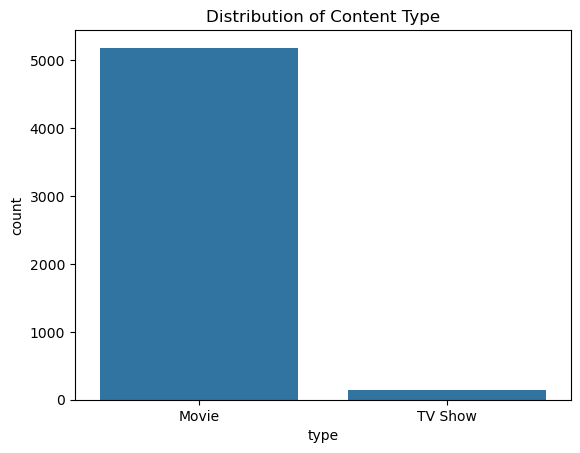

In [18]:
sns.countplot(data=df, x='type')
plt.title("Distribution of Content Type")
plt.show()

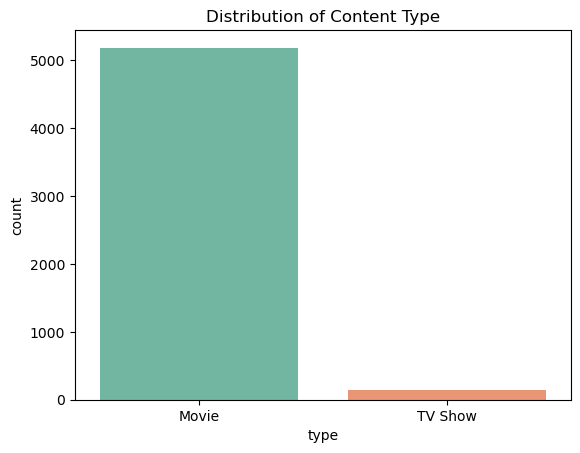

In [19]:
sns.countplot(data=df, x='type', palette='Set2')
plt.title("Distribution of Content Type");
plt.show()

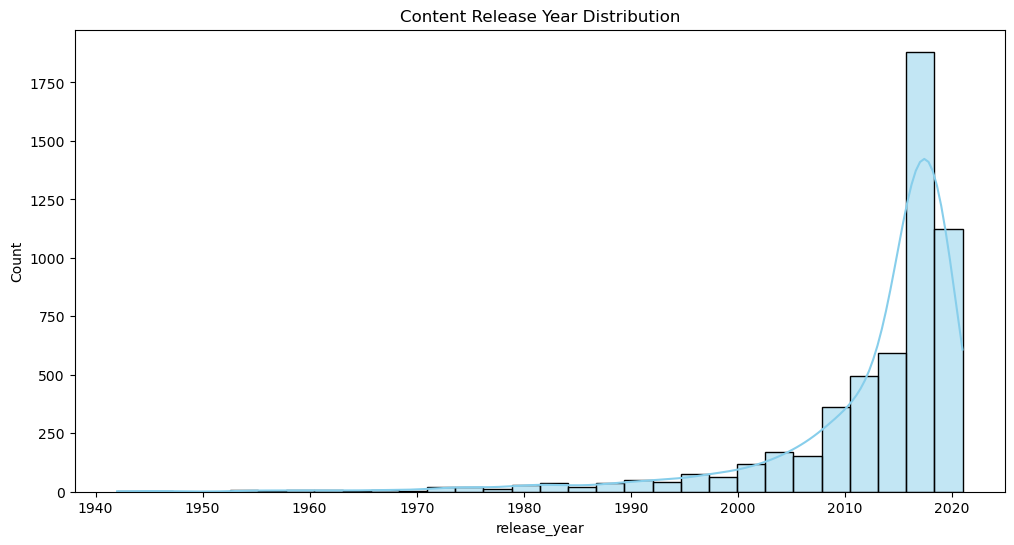

In [20]:
plt.figure(figsize=(12,6))
sns.histplot(data=df, x='release_year', bins=30, kde=True, color='skyblue')
plt.title("Content Release Year Distribution");
plt.show()


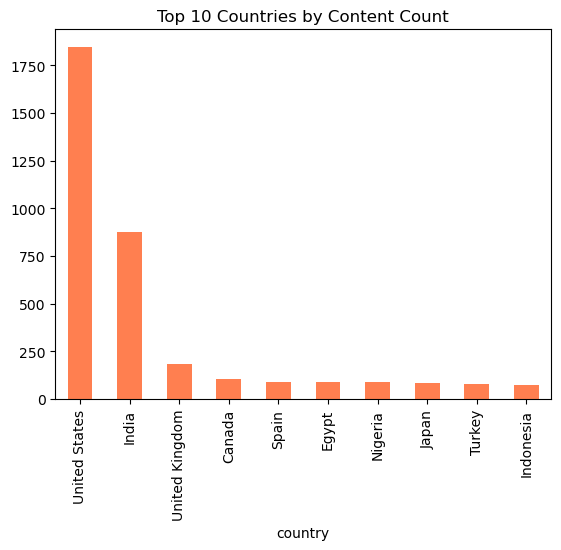

In [21]:
top_countries = df['country'].value_counts().head(10)
top_countries.plot(kind='bar', color='coral')
plt.title("Top 10 Countries by Content Count");
plt.show()


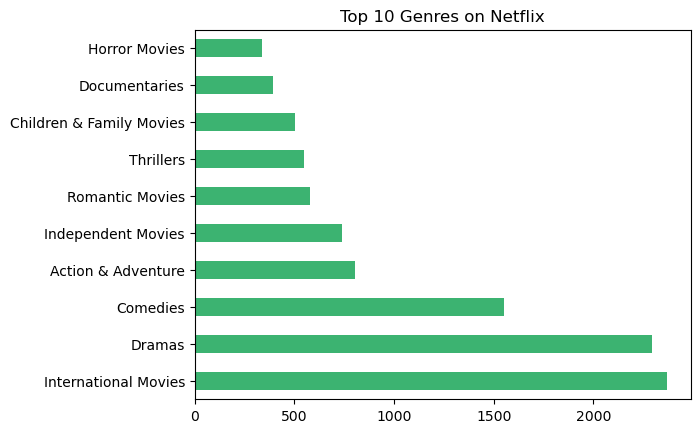

In [22]:
from collections import Counter
genres = df['listed_in'].str.split(', ')
flat_genres = [genre for sublist in genres.dropna() for genre in sublist]
genre_counts = pd.Series(Counter(flat_genres)).sort_values(ascending=False).head(10)
genre_counts.plot(kind='barh', color='mediumseagreen')
plt.title("Top 10 Genres on Netflix");
plt.show()


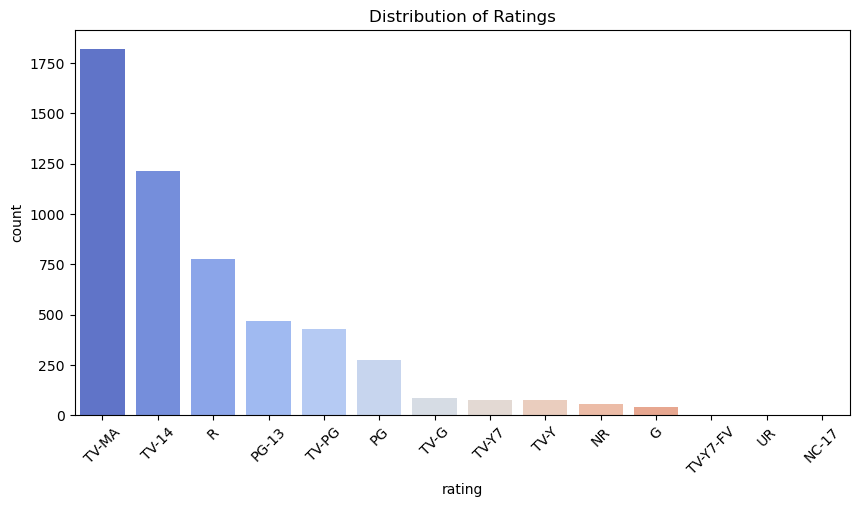

In [23]:
plt.figure(figsize=(10,5))
sns.countplot(data=df, x='rating', order=df['rating'].value_counts().index, palette='coolwarm')
plt.title("Distribution of Ratings")
plt.xticks(rotation=45)
plt.show()


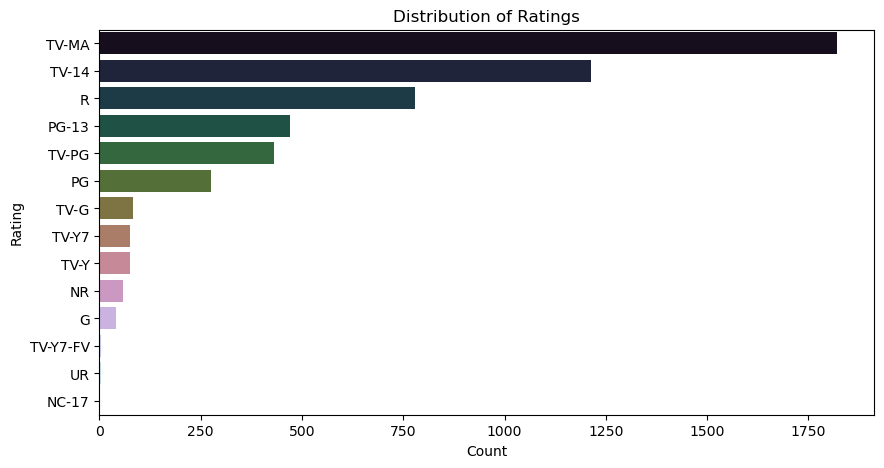

In [24]:
# 2. Distribution of Ratings
# ===============================
plt.figure(figsize=(10,5))
sns.countplot(y='rating', data=df, order=df['rating'].value_counts().index, palette='cubehelix')
plt.title("Distribution of Ratings")
plt.xlabel("Count")
plt.ylabel("Rating")
plt.show()

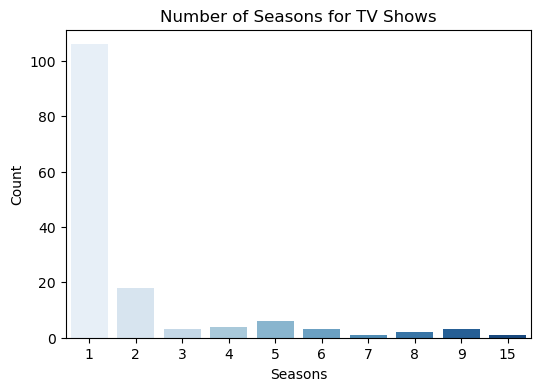

In [25]:
# TV Show Seasons Distribution
# ===============================
tv_df = df[df['type'] == 'TV Show'].copy()
tv_df['seasons_int'] = tv_df['duration'].str.replace(' Season', '').str.replace('s', '').astype(int)

plt.figure(figsize=(6,4))
sns.countplot(x='seasons_int', data=tv_df, palette='Blues')
plt.title("Number of Seasons for TV Shows")
plt.xlabel("Seasons")
plt.ylabel("Count")
plt.show()

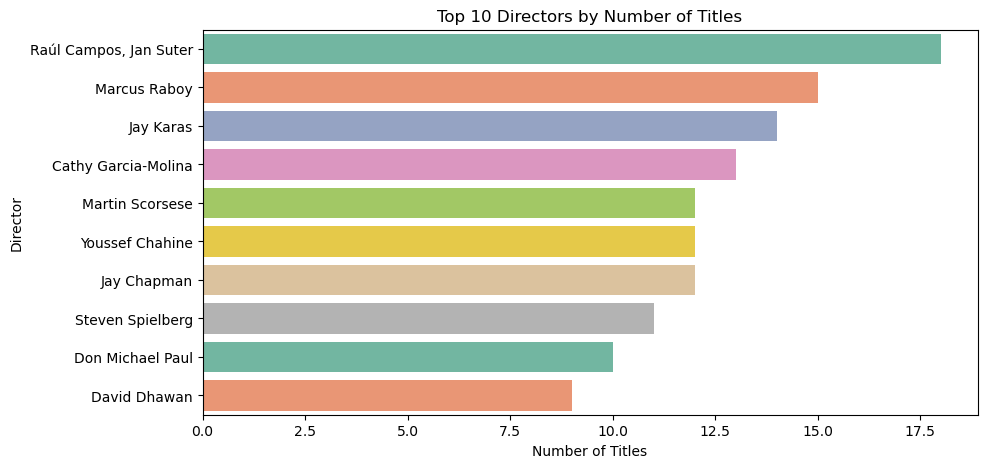

In [26]:
# Top Directors
# ===============================
plt.figure(figsize=(10,5))
top_directors = df[df['director'] != 'Unknown']['director'].value_counts().head(10)
sns.barplot(x=top_directors.values, y=top_directors.index, palette='Set2')
plt.title("Top 10 Directors by Number of Titles")
plt.xlabel("Number of Titles")
plt.ylabel("Director")
plt.show()


In [27]:
def extract_duration(value):
    if 'min' in value:
        return int(value.replace('min', '').strip())
    elif 'Season' in value:
        return int(value.split()[0]) * 60  # Approximate 1 season = 60 min
    else:
        return None

df['duration_num'] = df['duration'].apply(extract_duration)


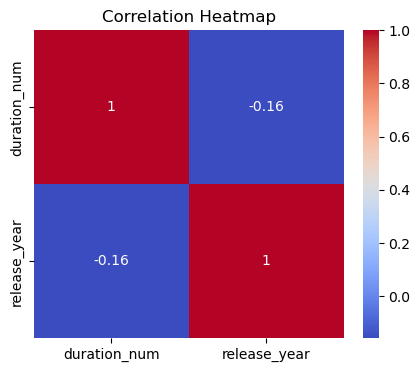

In [28]:
#  Heatmap: Correlation of Numeric Columns
# ===============================
plt.figure(figsize=(5,4))
numeric_cols = df[['duration_num', 'release_year']]
sns.heatmap(numeric_cols.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

## EDA with visualizations

### Movies vs TV Shows distribution

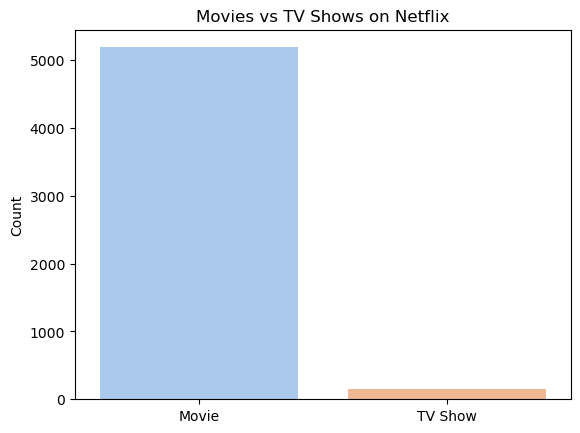

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x='type', data=df, palette='pastel')
plt.title("Movies vs TV Shows on Netflix")
plt.xlabel("")
plt.ylabel("Count")
plt.show()


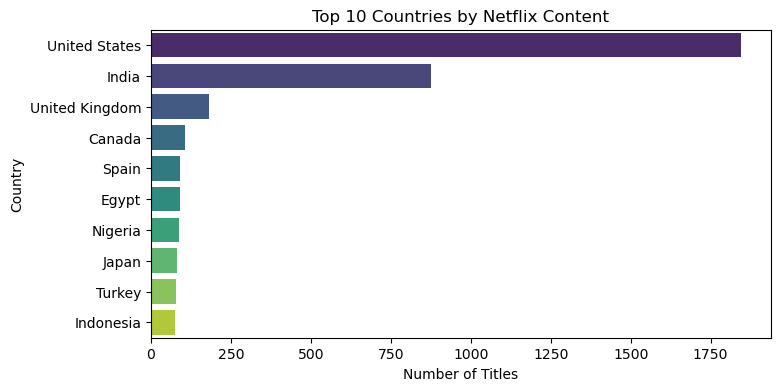

In [30]:
# 3. Top 10 Countries by Content
# -----------------------
plt.figure(figsize=(8,4))
top_countries = df['country'].value_counts().head(10)
sns.barplot(x=top_countries.values, y=top_countries.index, palette='viridis')
plt.title("Top 10 Countries by Netflix Content")
plt.xlabel("Number of Titles")
plt.ylabel("Country")
plt.show()

In [31]:
# 4. Content Added Over the Years
# -----------------------
import plotly.express as px

# Safely convert 'date_added' to datetime
df['date_added'] = pd.to_datetime(df['date_added'], format='mixed', errors='coerce')

# Extract year from cleaned 'date_added'
df['year_added'] = df['date_added'].dt.year

# Count titles per year added
yearly_additions = df['year_added'].value_counts().sort_index()

# Create Plotly line chart
fig = px.line(
    x=yearly_additions.index,
    y=yearly_additions.values,
    labels={'x': 'Year Added', 'y': 'Number of Titles'},
    title='Content Added to Netflix Over the Years',
    markers=True
)

fig.update_traces(line=dict(color='coral'))
fig.update_layout(template='plotly_white')
fig.show()




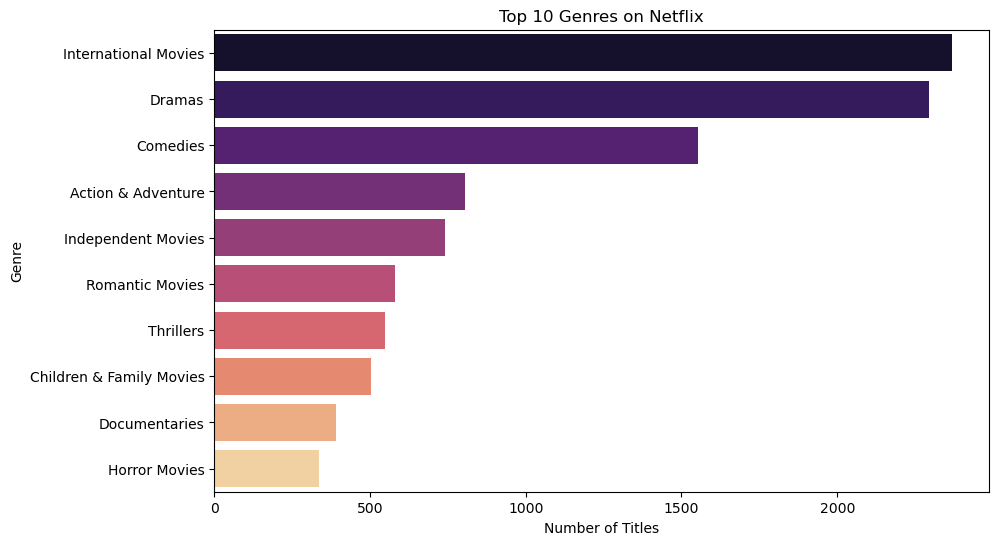

In [32]:
# 5. Most Popular Genres
# -----------------------
plt.figure(figsize=(10,6))
# Split 'listed_in' by comma and count frequency
genre_series = df['listed_in'].str.split(',').explode().str.strip()
top_genres = genre_series.value_counts().head(10)
sns.barplot(x=top_genres.values, y=top_genres.index, palette='magma')
plt.title("Top 10 Genres on Netflix")
plt.xlabel("Number of Titles")
plt.ylabel("Genre")
plt.show()

In [33]:
# Clean and explode genres
df['year_added'] = pd.to_datetime(df['date_added'], format='mixed', errors='coerce').dt.year
df['genres'] = df['listed_in'].str.split(', ')
genre_trends = df.explode('genres').groupby(['year_added', 'genres']).size().unstack().fillna(0)

# Plot with Plotly
import plotly.express as px
genre_trends_filtered = genre_trends.loc[:, genre_trends.sum().sort_values(ascending=False).head(5).index]
fig = px.line(genre_trends_filtered, labels={'value': 'Number of Titles', 'year_added': 'Year'}, title='Top Genres Over Time')
fig.show()


In [34]:
df['country'] = df['country'].fillna('Unknown')
country_trends = df.groupby(['release_year', 'country']).size().unstack().fillna(0)
top_countries = country_trends.sum().sort_values(ascending=False).head(5).index
country_trends_filtered = country_trends[top_countries]

fig = px.line(country_trends_filtered, labels={'value': 'Number of Titles', 'release_year': 'Release Year'}, title='Top Countries by Content Over Time')
fig.show()


In [35]:
top_directors = df['director'].value_counts().dropna().head(10)
top_cast = df['cast'].dropna().str.split(', ').explode().value_counts().head(10)

print("Top Directors:\n", top_directors)
print("\nTop Cast Members:\n", top_cast)


Top Directors:
 director
Raúl Campos, Jan Suter    18
Marcus Raboy              15
Jay Karas                 14
Cathy Garcia-Molina       13
Martin Scorsese           12
Youssef Chahine           12
Jay Chapman               12
Steven Spielberg          11
Don Michael Paul          10
David Dhawan               9
Name: count, dtype: int64

Top Cast Members:
 cast
Anupam Kher         42
Shah Rukh Khan      34
Naseeruddin Shah    31
Akshay Kumar        30
Om Puri             30
Amitabh Bachchan    28
Paresh Rawal        28
Boman Irani         27
Kareena Kapoor      25
Ajay Devgn          21
Name: count, dtype: int64


In [36]:
df['month_added'] = pd.to_datetime(df['date_added'], format='mixed', errors='coerce').dt.month
monthly_additions = df['month_added'].value_counts().sort_index()

fig = px.bar(x=monthly_additions.index, y=monthly_additions.values,
             labels={'x': 'Month', 'y': 'Number of Titles'},
             title='Monthly Content Addition Trend')
fig.update_layout(xaxis=dict(tickmode='array', tickvals=list(range(1,13)), ticktext=[
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']))
fig.show()


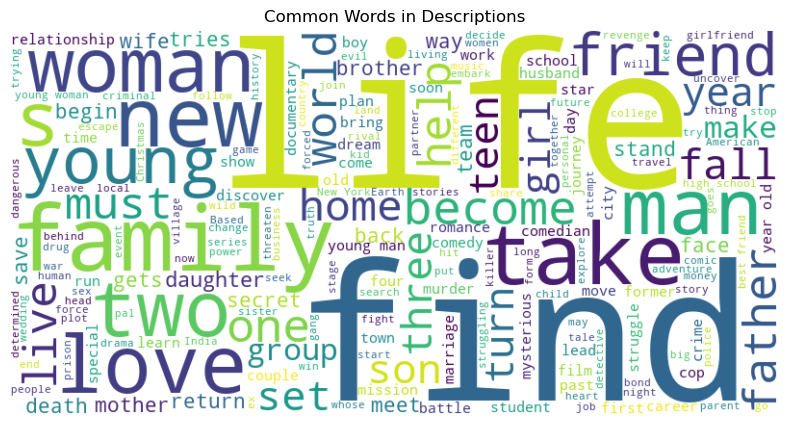

In [37]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = ' '.join(df['description'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Common Words in Descriptions")
plt.show()


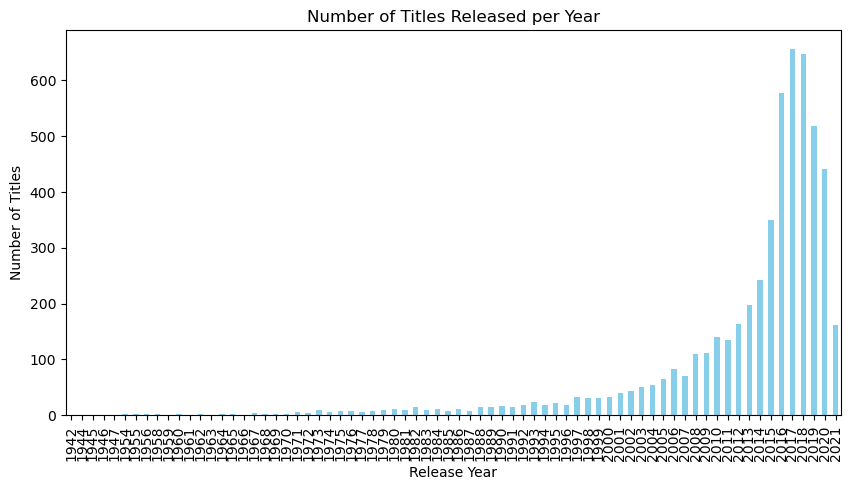

In [38]:
# 6. Release Year Patterns
# -----------------------
plt.figure(figsize=(10,5))
df['release_year'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title("Number of Titles Released per Year")
plt.xlabel("Release Year")
plt.ylabel("Number of Titles")
plt.show()

In [39]:
import plotly.express as px

# Count titles per release year
release_counts = df['release_year'].value_counts().sort_index()

# Create Plotly line chart
fig = px.line(
    x=release_counts.index,
    y=release_counts.values,
    labels={'x': 'Release Year', 'y': 'Number of Titles'},
    title='Number of Titles Released per Year'
)

fig.show()


In [40]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Preprocessing
df['duration_num'] = df['duration'].str.extract('(\d+)').astype(float)
df_model = df[['type', 'duration_num', 'release_year']].dropna()

# Encode target
df_model['type'] = df_model['type'].map({'Movie': 0, 'TV Show': 1})

# Split data
X = df_model[['duration_num', 'release_year']]
y = df_model['type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1035
           1       0.97      1.00      0.98        32

    accuracy                           1.00      1067
   macro avg       0.98      1.00      0.99      1067
weighted avg       1.00      1.00      1.00      1067



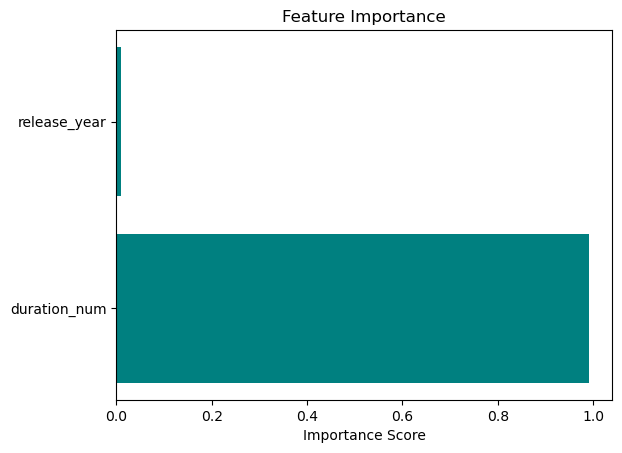

In [41]:
import matplotlib.pyplot as plt

importances = model.feature_importances_
features = X.columns

plt.barh(features, importances, color='teal')
plt.title("Feature Importance")
plt.xlabel("Importance Score")
plt.show()
